# CNN for Fundamental Respiration Sound Recognition

### Introduction

In this Norebook we developed a simple convolutional neural network (CNN) and trained it to recognize the fundamental respiration sounds, inspiration and expiration.

### Libraries Needed

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential

from ipywidgets import widgets, interact

import pandas as pd
import numpy as np
import librosa as lb
from tqdm import tqdm
import soundfile as sfile
import librosa.display as lbdis
import matplotlib.pyplot as plt
%matplotlib inline


# changing to database path
import os
import sys
from os.path import dirname as up
mf_path = (up(os.getcwd())).replace('\\','/')    # Main Folder Path
sys.path.insert(1, mf_path)

import aidiagnostics_toolbox as aidt
import glob
os.chdir(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files')

### Data Loading Process

Lets first import is the **aidiagnostics_labels.csv** file which contain the labels for patient 105 sound recording. 

In [2]:
lp = mf_path + '/aidiagnostics_labels.csv'
lbs = pd.read_csv(lp)                 #  Labels 
sn = np.array(lbs.columns.values)     #  Names of recordings labelled

print('sound labelled: ', sn[0])

sound labelled:  105_1b1_Tc_sc_Meditron


Then lets upload the waveform and the actual label vector.

In [3]:
# Initializing Variables
sound_reco = []
sf_reco = []
sound_lbs = []
p=0
# Loading Loop
for file in tqdm(sn):
    data, sf = sfile.read(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files/' + file + '.wav')
    data = data[0:sf*int(data.shape[0]/sf)]
    sound_reco.append(data)
    sf_reco.append(sf)
    # loading labels
    po = np.array(lbs.iloc[:,p])
    po = po[~np.isnan(po)]
    sound_lbs.append(po[0:sf*int(data.shape[0]/sf)])
    p += 1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Now, lets normalize the amplitude of the recording and then see how the labels look over the signal.

C:\Users\kevin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


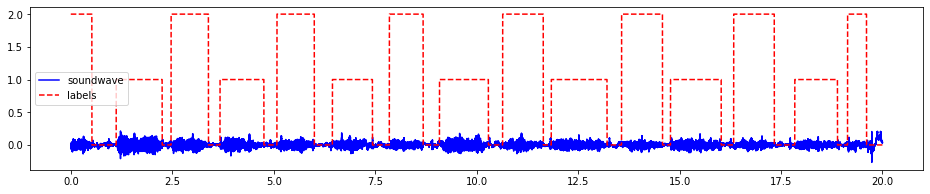

In [33]:
# Data Normalization
X = np.divide(data, max(data))
X = X - np.mean(X)
X = np.divide(X, np.max(X))

vt = np.linspace(0,len(X)/sf,len(X))
# Ploting 
plt.figure(figsize=(16,3))
plt.plot(vt, sound_reco[0], 'b', label = 'soundwave')#, label = 'waveform')
plt.plot(vt, sound_lbs[0], 'r--', label = 'labels')
plt.legend()
plt.show()

### A kind of Data Augmentation

Whenever there is no enough data to train our models we can develop a data augmentation procedure. In this case, from a sigle sound we will generate 4 images: a Spectrogram, a Mel Spectrogram, the Harmonics and the Percussive os a Mel Spectrogram.

Lets calculate the spectrogram first

In [ ]:
# Calculate Spectrogram

Now, lets calculate the Mel-Spectrogram, its Harmonics and Percussive form

In [15]:
# Mel spectrogram
Mspec = lb.feature.melspectrogram(X, sr=sf, n_mels=128)
# Convert to log scale (dB)
Mspec_db = lb.power_to_db(Mspec, ref=np.max)

# Harmonic & Percussive
y_harmonic, y_percussive = lb.effects.hpss(X)

S_harmonic   = lb.feature.melspectrogram(y_harmonic)
S_percussive = lb.feature.melspectrogram(y_percussive)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = lb.power_to_db(S_harmonic, ref=np.max)
log_Sp = lb.power_to_db(S_percussive, ref=np.max)

In [26]:
len(X)/sf

20.0

In [32]:
vt = np.linspace(0,len(X)/sf,len(X))
print(len(vt),len(X))

882000 882000


now we can plot the augmented data, each of them with the same label vector

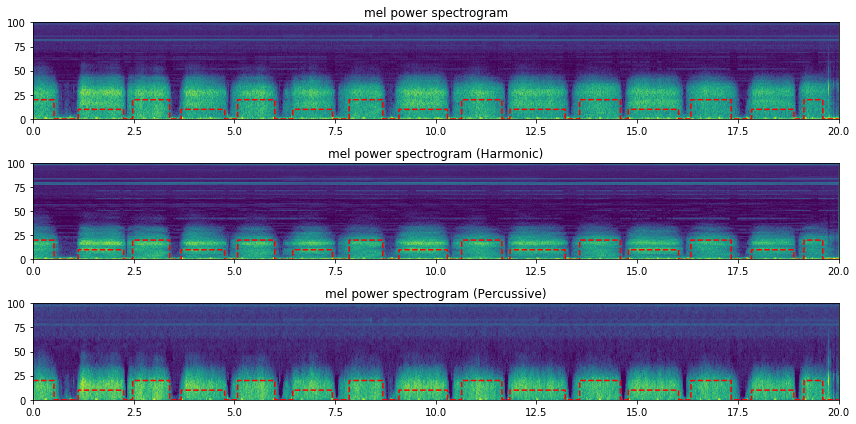

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(Mspec_db, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vt, 10*sound_lbs[0], 'r--')
plt.title('mel power spectrogram')
plt.subplot(3,1,2)
plt.imshow(log_Sh, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vt, 10*sound_lbs[0], 'r--')
plt.title('mel power spectrogram (Harmonic)')
plt.subplot(3,1,3)
plt.imshow(log_Sp, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vt, 10*sound_lbs[0], 'r--')
plt.title('mel power spectrogram (Percussive)')
plt.tight_layout()